<a href="https://colab.research.google.com/github/MarcoLaud/DynamicsOfMetamaterials_DataAnalysis/blob/main/BoundaryLayers_Pantograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Boundary layer in a 2D pantographic material under large deformation regime**

In this code we plot the boundary layers around the clamping region of a pantographic material undergoind large dynamical deformations. The strategy is to select a line passing through the clamping region. It will be the object of the investigation and we will observe its shape at given instant of time and we hope to observe second gradient signatures.

We define the functions that we will use later.

In [ ]:
"""
@author: Marco Laudato - marco@marcolaudato.com
"""

from numpy import arctan, asarray, cos, gradient, isclose, isnan, load,\
    matmul, nan, sin, where, zeros, zeros_like
from matplotlib.pyplot import axis, figure, legend, pcolor, plot
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit


def build_discrete_line(xx, yy, m, q):
    '''
    Build the approximation on the specimen's mesh of the line y=m*xx + q.

    Input:
      * xx: array with x-coordinates of the mesh.
      * yy: array with y-coordinates of the mesh.
      * m: angular parameter of the line.
      * q: offset of the line (usually zero).

    Output:
      * discrete_line: array with the resampled y-values of the line on the
                       specimen's mesh.
      * indeces_along_y: indeces on the y-coordinates of the mesh associated to
                         the previous values.
    '''
    continuous_line = zeros_like(xx)
    discrete_line = zeros_like(xx)
    indices_along_y = zeros_like(xx)

    # Tolerance in the resampling of the curve on the mesh.
    # The mesh elements are equispaced. 
    tol = (yy[1] - yy[0]) / 2

    continuous_line = asarray([m*x + q for x in xx])

    for ii in range(len(continuous_line)):
        '''
        Resampling of the line on the specimen's mesh.
        We save in "discrete_line" the value on the mesh y-coordinates which is
        the closest to the value of the line, for every point of the mesh
        x-coordinates.
        We save also the indeces associated to the original camera frame mesh
        relative to the y-values of the line => needed later in
        "deform_the_line" to access to the right points of the vector field
        arrays, whose mesh is relative to original mesh of the camera frame.
        '''
        index_y = where(isclose(yy, continuous_line[ii], atol=tol))
        indices_along_y[ii] = index_y[0][0]
        discrete_line[ii] = yy[index_y[0][0]]

    return discrete_line, indices_along_y


def deform_the_line(xx, starting_line, indeces_x, indeces_y,
                    x_displ, y_displ):
    '''
    Deform the starting line by using the displacement vector fields along x
    and y at a given instant of time.

    Input:
      * xx: array with x-coordinates of the mesh where the sample actually is.
      * starting_line: array with the y values of the resampled starting line.
      * indeces_x: indeces of the original camera frame mesh relative to xx.
      * indeces_y: indeces of the original camera frame mesh relative to the
                   values of "starting_line".
      * x_displ: 2D array with the x-component of the displacement vector field
                 evaluated at time t.
      * y_displ: 2D array with the x-component of the displacement vector field
                 evaluated at time t.
      * t: instant of time at which the vector fields are evaluated.
    Output:
      * deformed_xx: array with the values of the x-coordinates of the line
                     after the deformation.
      * deformed_line: array with the values of the y-coordinates of the line
                     after the deformation.
    '''  
    deformed_line = zeros_like(starting_line)
    deformed_xx = zeros_like(starting_line)
    deformed_line[:] = nan
    deformed_xx[:] = nan

    '''
      If the line passes through a hole in the specimen, the corresponding
      displacement will be zero for every t. Here we remove those points from
      the deformed line. The gaps will be filled by the fit.
      '''
    for ii in range(len(xx)):
        if (x_displ[int(indeces_x[ii]), int(indeces_y[ii])] == 0 and
           y_displ[int(indeces_x[ii]), int(indeces_y[ii])] == 0):
            pass
        else:
            deformed_xx[ii] = xx[ii] + x_displ[int(indeces_x[ii]),
                                               int(indeces_y[ii])]
            deformed_line[ii] = starting_line[ii] +\
                y_displ[int(indeces_x[ii]), int(indeces_y[ii])]

    return deformed_xx, deformed_line


def fit_function(xx, a, b, c):
    '''
    Function used to perform the fit of the deformed line.
    Input:
      * xx: array with the independent variables.
      * the rest are the parameters of the function that will be fit.
    Output:
      * returns the y-values of the function in an array.
    '''
    return a*xx**2 + b*xx + c


def line_parameters(x0, y0, x1, y1):
    '''
    Compute the parameters of a continuous line on the pantograph given two
    points (x0, y0) and (x1, y1)
    '''
    m = (y1 - y0) / (x1 - x0)
    q = y1 - m*x1

    return m, q


def fiber_derivative(xx, x_displ, y_displ, indeces_x, indeces_y, m):
  '''
  Compute the derivative of the displacement of a fiber along the fiber
  direction.
  Input:
    * xx: array with x-coordinates of the mesh where the sample actually is.
    * x_displ: 2D array with the x-component of the displacement vector field
               evaluated at time t.
    * y_displ: 2D array with the x-component of the displacement vector field
               evaluated at time t.
    * indeces_x: indeces of the original camera frame mesh relative to xx.
    * indeces_y: indeces of the original camera frame mesh relative to the
                 values of "starting_line".
    * m: The angular parameter of the fiber continuous line.
  '''
  tmp = zeros((2, x_displ[:, :, tt].size))
  tmp[0] = x_displ[:, :, tt].ravel()
  tmp[1] = y_displ[:, :, tt].ravel()

  # We need to rotate the vector fields w.r.t. the direction of the fiber
  theta = arctan(m)
  R = [[cos(theta), sin(theta)], [-sin(theta), cos(theta)]]
  rot_displ = matmul(R, tmp)

  x_displ_rot = rot_displ[0].reshape(x_displ[:, :, tt].shape)
  y_displ_rot = rot_displ[1].reshape(x_displ[:, :, tt].shape)
  y_zero = zeros(len(xx_red))

  def_xx_rot, def_line_rot = deform_the_line(xx_red, y_zero, ind_along_x,
                                              ind_along_y, x_displ_rot,
                                              y_displ_rot)

  # Fit of the deformed function with cubic spline.
  def_xx_rot = asarray([elem for elem in def_xx_rot if not isnan(elem)])
  def_line_rot = asarray([elem for elem in def_line_rot if not isnan(elem)])
  def_xx_rot.sort()
  spline_rot = UnivariateSpline(def_xx_rot, def_line_rot, k=3)

  # Computation of the derivative of the fit cubic spline.
  dx = xx[1] - xx[0]
  dspline_rot = gradient(spline_rot(xx), dx)

  return spline_rot, dspline_rot

## Loading data and focus on the sample
We load the data from Google Drive and we assign the variables. Note that we re-center the coordinate system.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# loading data and variables assignment 
data = load('/content/gdrive/MyDrive/data/ET_A=200.npz')

xx = data['x']
xx -= xx[0]
yy = data['y']
yy -= yy[0]

x_displ = data['xt']
y_displ = data['yt']

## Build up the reference configuration and the starting line

We start by plotting the reference configuration and defining the time instant $t$ at which we want to evaluate the deformation. The camera data that we have recorded have maximum 400 frames.

The frame of the camera is larger than the sample. Therefore we need to focus the frame on the pantographic structure.

In [ ]:
# plot parameters to focus on the clamping area
# array indeces:
left = 50
right = 350
down = 20
up = 280

# time instant:
tt = 156        # t <= 400

(19.005000591299996, 132.65490412719998, 7.602000236500004, 106.0479032993)

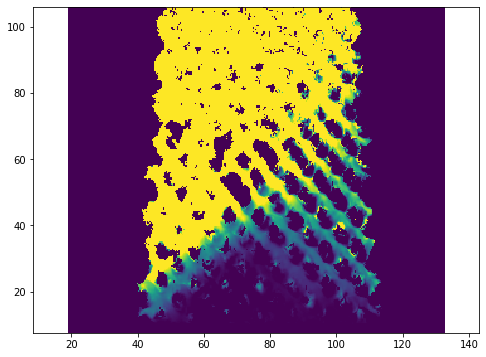

In [ ]:
# plot the reference configuration
ref_configuration = zeros((len(yy), len(xx)))
ref_configuration += x_displ[:, :, tt].T
ref_configuration += y_displ[:, :, tt].T

figure(figsize=(8, 6))
pcolor(xx[left:right], yy[down:up], ref_configuration[down:up, left:right],
       vmin=0, vmax=1)
axis('equal')

We can specify the parameters of the starting curve. In the current implementation the line is defined by giving the starting and final points' coordinates on the specimen geometry.




In [ ]:
# starting point
x0 = 46.4542
y0 = 73.1281
# final point
x1 = 100.658
y1 = 11.34

# we need to limit the x-coordinates of the line to the specimen geometry
xx_red = []
ind_along_x = []

for ii, x in enumerate(xx):
    if x >= x0 and x <= x1:
        xx_red.append(x)
        ind_along_x.append(ii)

xx_red = asarray(xx_red)

mm, qq = line_parameters(x0, y0, x1, y1)

We can now build up the approximation of the line on the sample mesh and plotting it.

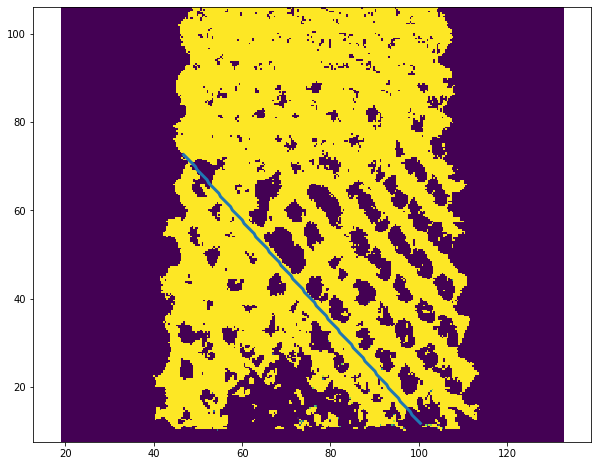

In [ ]:
# build up the discrete approximation of the line on the ref configuration mesh
discr_line, ind_along_y = build_discrete_line(xx_red, yy, mm, qq)
figure(figsize=(10, 8))
pcolor(xx[left:right], yy[down:up], ref_configuration[down:up, left:right],
       vmin=0, vmax=0.001)
axis('equal')
plot(xx_red, discr_line, linewidth=3, label='starting line')

## Deforming the line and performing the fit

Here we deform the starting line with the vector field measured by the camera at time $t$.

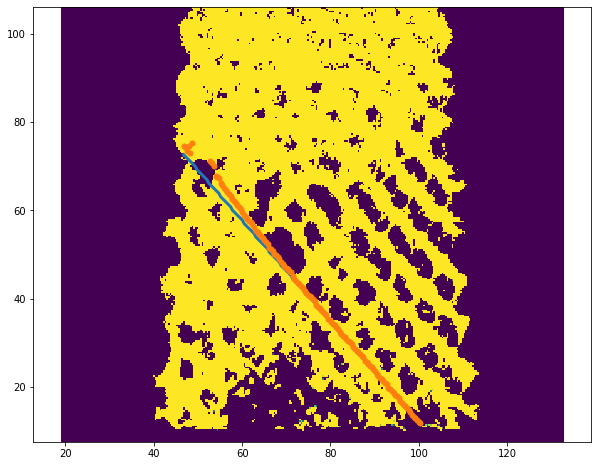

In [ ]:
# deform the line and plot on the ref configuration
def_xx, def_line = deform_the_line(xx_red, discr_line, ind_along_x,
                                   ind_along_y, x_displ[:, :, tt],
                                   y_displ[:, :, tt])

figure(figsize=(10, 8))
pcolor(xx[left:right], yy[down:up], ref_configuration[down:up, left:right],
       vmin=0, vmax=0.001)
axis('equal')
plot(xx_red, discr_line, linewidth=3, label='Starting')
plot(xx_red, def_line, linewidth=0, marker='o', markersize=5, label='Deformed line')

The result of this deformation will be a non-continuous curved line. The reason is that the displacement vector field is vanishing in the gaps of the specimen. Consequently, we are neglegting all the points that are in the holes. In order to have a more meaningful shape to analyse, it is convenient to perform a fit of this trajectory. 

Therefore, we firstly remove all the *NaNs* from the array and then we perform a fit with the function defined earlier. The parameters of the fit will be then used to plot the fit curve which represents the wanted *boundary layer*.

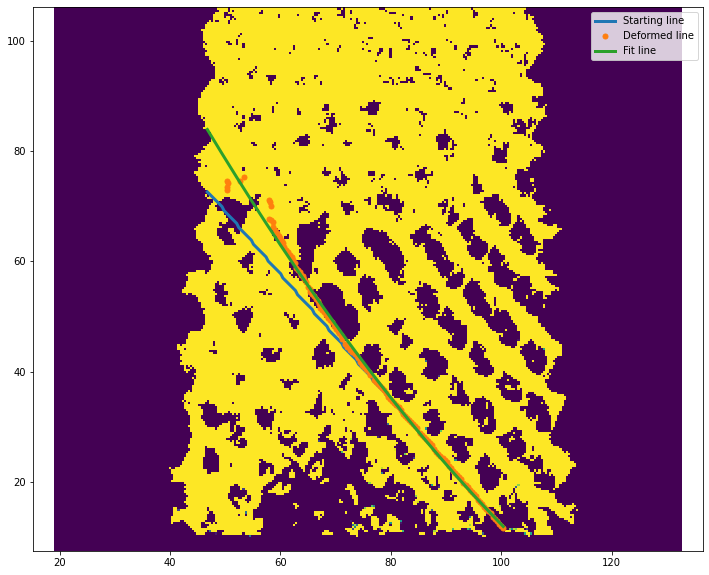

In [ ]:
# fit the boundary layer with fit_function:

# remove the nans
def_xx = asarray([elem for elem in def_xx if not isnan(elem)])
def_line = asarray([elem for elem in def_line if not isnan(elem)])

# fit here:
popt, pcov = curve_fit(fit_function, def_xx, def_line)
fitted_y = fit_function(xx_red, popt[0], popt[1], popt[2])

figure(figsize=(12, 10))
pcolor(xx[left:right], yy[down:up], ref_configuration[down:up, left:right],
       vmin=0, vmax=0.001)
axis('equal')
plot(xx_red, discr_line, linewidth=3, label='Starting line')
plot(def_xx, def_line, linewidth=0, marker='o', markersize=5,
     label='Deformed line')
plot(xx_red, fitted_y, linewidth=3, label='Fit line')
legend()

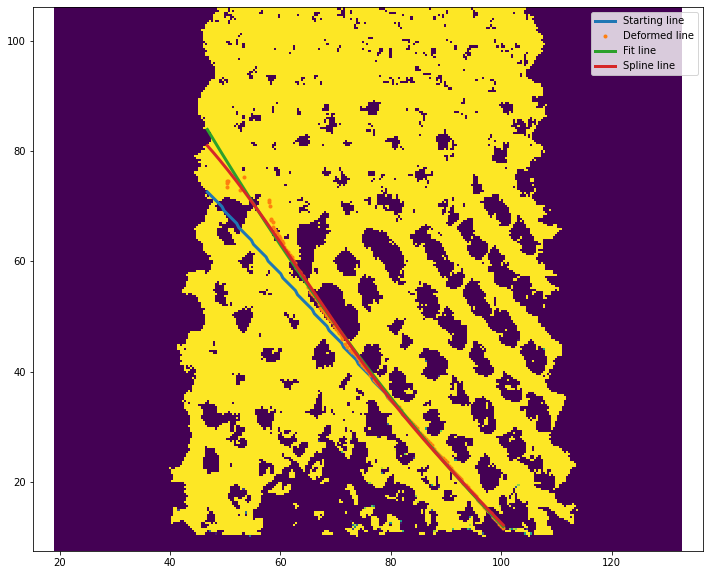

In [ ]:
# fit the deformed line with cubic spline:

def_xx.sort()

spline = UnivariateSpline(def_xx, def_line, k=3)

figure(figsize=(12, 10))
pcolor(xx[left:right], yy[down:up], ref_configuration[down:up, left:right],
       vmin=0, vmax=0.001)
axis('equal')
plot(xx_red, discr_line, linewidth=3, label='Starting line')
plot(def_xx, def_line, linewidth=0, marker='o', markersize=3, 
     label='Deformed line')
plot(xx_red, fitted_y, linewidth=3, label='Fit line')
plot(xx_red, spline(xx_red), linewidth=3, label='Spline line')
legend()

## Derivative of the displacement along the fiber direction

We can now compute the derivative of the cubic spline obtained by the fit w.r.t. the direction of the fiber.

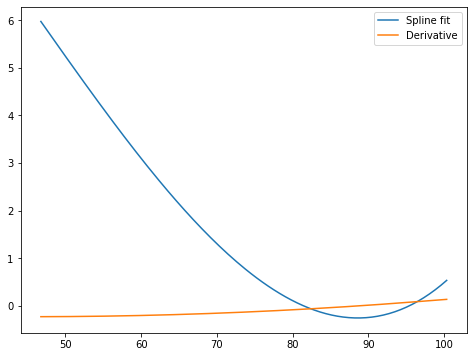

In [ ]:
spline_fiber, der_spline_fiber = fiber_derivative(xx_red, x_displ, y_displ,
                                                  ind_along_x, ind_along_y, mm)

figure(figsize=(8, 6))
plot(xx_red, spline_fiber(xx_red), label='Spline fit')
plot(xx_red, der_spline_fiber, label='Derivative')
legend()